In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [7]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.982238424867056

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [8]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    ### your code here
    
    samples = [set(np.random.choice(X.shape[0], X.shape[0])) for i in range(num_runs)]
    b = {i for i in range(X.shape[0])}
    t_samples = [b.difference(a) for a in samples]

    predictions = []

    for i in range(num_runs):
        X_train = X[list(samples[i])]
        X_test = X[list(t_samples[i])]
        y_train = y[list(samples[i])]
    
        regressor.fit(X_train, y_train)
        predictions.append({list(t_samples[i])[j] : regressor.predict([X_test[j]])[0] for j in range(len(t_samples[i]))})
    
    bias = np.mean([(y[i] - np.mean([p[i] for p in predictions if i in p.keys()])) ** 2 for i in range(len(y))])
    variance = np.mean([np.mean([(pb[i] - np.mean([p[i] for p in predictions if i in p.keys()])) ** 2 
                                 for pb in predictions if i in pb.keys()]) for i in range(len(y))])
    error = np.mean([np.mean([(y[i] - p[i]) ** 2 for p in predictions if i in p.keys()]) for i in range(len(y))])
    
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [10]:
### your code here
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

L = LinearRegression()
D = DecisionTreeRegressor()
R = RandomForestRegressor()

for regressor in (L, D, R):
    print(compute_biase_variance(regressor, X, y))

(23.75147302091916, 0.5943232534880332, 24.34579627440719)
(10.461194917707713, 12.732734845597767, 23.19392976330548)


/home/alexey/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


(11.063109499902616, 2.7426262581682366, 13.805735758070856)


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на семинарах (с комментарием)?

__Your answer here:__ 

Во-первых, сумма смещения и дисперсии действительно равна ошибке на каждом алгоритме, что подтверждает правильность вычислений. Как и ожидалось, линейная регрессия имеет маленькое отклонение, поскольку алгоритм не чувствителен к незначительным изменениям выборки, однако сложные зависимости восстанавливаются трудно, а потому смещение велико. С деревьями ситуация иная. Они могут восстановить сложные зависимости, но очень быстро переобучаются. А потому смещение меньше, но отклонение гораздо больше. Наконец, случайные леса помогат уменьшить дисперсию деревьев, не измения при этом смещение. Отдельно стоит отметить, что все три алгоритма имеют похожую ошибку

__3. (1 балл)__
Вспомните обсуждение с лекции о том, во сколько раз в теории бутстрап уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.



__Your answer here:__ Бутстрап уменьшает разброс базового алгоритма в *N* раз, однако у нас этого не наблюдается. Сказывается корелляция в данных, предположений о которой мы не делали

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__4. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [246]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = num_test_objects)

    samples = [set(np.random.choice(X_train.shape[0], X_train.shape[0])) for i in range(num_runs)]
    b = {i for i in range(X_train.shape[0])}
    t_samples = [b.difference(a) for a in samples]

    predictions = []

    for i in range(num_runs):
        X_train_1 = X_train[list(samples[i])]
        X_test_1 = X_train[list(t_samples[i])]
        y_train_1 = y_train[list(samples[i])]
    
        regressor.fit(X_train_1, y_train_1)
        predictions.append(regressor.predict(X_test))
    plt.ylim(0, 55)
    plt.scatter(list(range(num_test_objects)) * num_runs, np.array(predictions), c = 'red')
    plt.scatter(np.arange(num_test_objects), y_test, c ='black')
    plt.title(title)


__5. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

/home/alexey/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


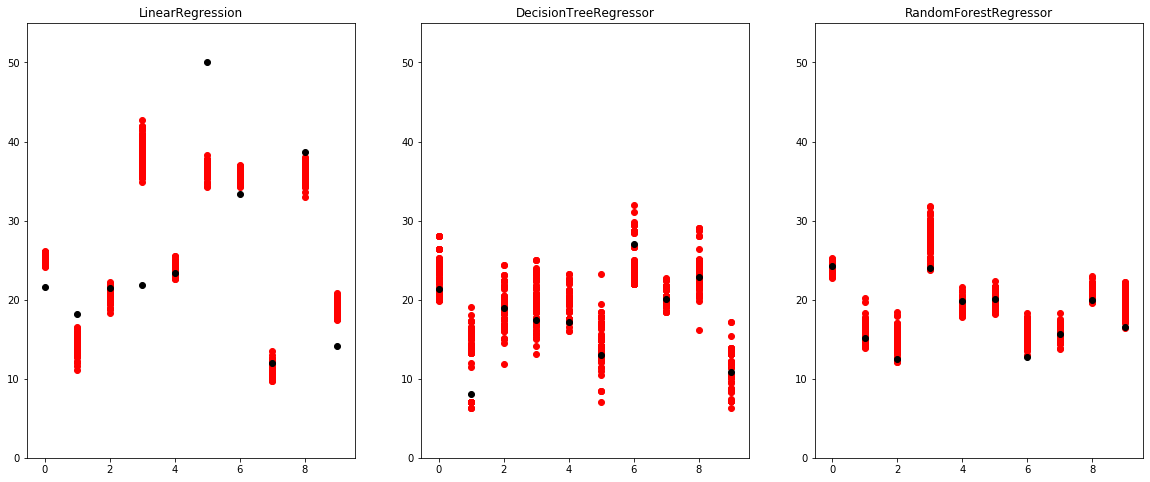

In [247]:
L = LinearRegression()
D = DecisionTreeRegressor()
R = RandomForestRegressor()


fig = plt.figure(figsize=(20, 8))
plt.subplot(131)
plot_predictions(L, X, y, title = 'LinearRegression')
plt.subplot(132)
plot_predictions(D, X, y, title = 'DecisionTreeRegressor')
plt.subplot(133)
plot_predictions(R, X, y, title = 'RandomForestRegressor')

__6. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ По графику видно, что предсказания линейной регрессии почти не имеют разброса, они распологаются сосредоточенно. Но предсказания могут сильно отставать от истинного, что и показывает большое смещение и маленькую дисперсию линейной регрессии.

Решающее дерево наоборот. Истинный ответ всегда попадает в область предсказания, однако область имеет большой разброс, что характеризует решающее дерево как алгоритм с меньшим смещением, но большой дисперсией. 

Наконец, случайный лес "наследует" небольшое смещение решающих деревьев, при этом уменьшая дисперсию. По графику видно, что предсказания сосредоточены около истинных ответов.

### Изменение bias и variance при изменении гиперпараметров

__7. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

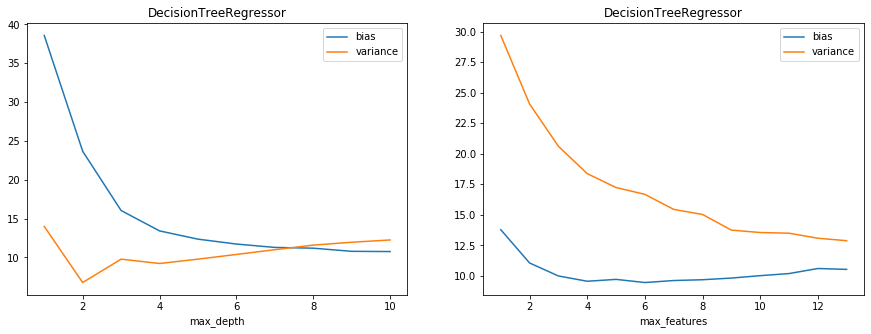

In [237]:
bias = []
variance = []
for max_depth in range(1, 11):
    D = DecisionTreeRegressor(max_depth=max_depth)
    b, v, _ = compute_biase_variance(D, X, y)
    bias.append(b)
    variance.append(v)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))
ax[0].plot(np.arange(1, 11), bias, label = "bias")
ax[0].plot(np.arange(1, 11), variance, label = "variance")
ax[0].set_xlabel("max_depth")
ax[0].legend()
ax[0].set_title("DecisionTreeRegressor")

bias = []
variance = []
for max_features in range(1, X.shape[1] + 1):
    D = DecisionTreeRegressor(max_features=max_features)
    b, v, _ = compute_biase_variance(D, X, y)
    bias.append(b)
    variance.append(v)

ax[1].plot(np.arange(1, X.shape[1] + 1), bias, label = "bias" )
ax[1].plot(np.arange(1, X.shape[1] + 1), variance, label = "variance")
ax[1].set_xlabel("max_features")
ax[1].set_title("DecisionTreeRegressor")
ax[1].legend()

plt.show()


__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

bias_r = []
variance_r = []
bias_gb = []
variance_gb = []
for n_estimators in 2**np.arange(1, 9):
    R = RandomForestRegressor(n_estimators = n_estimators)
    GB = GradientBoostingRegressor(n_estimators = n_estimators)
    b, v, _ = compute_biase_variance(R, X, y)
    bias_r.append(b)
    variance_r.append(v)
    
    b, v, _ = compute_biase_variance(GB, X, y)
    bias_gb.append(b)
    variance_gb.append(v)
        

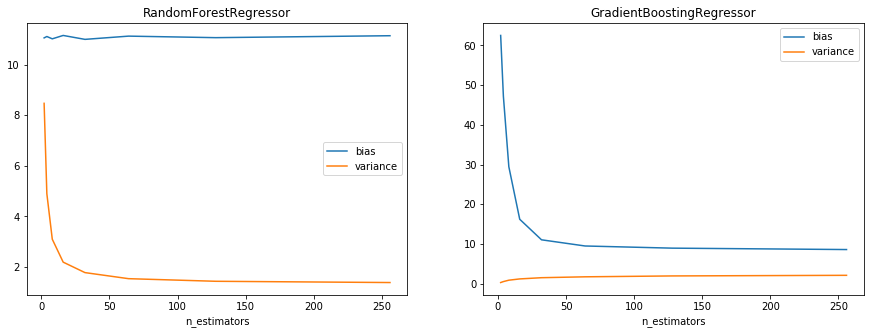

In [240]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

ax[1].plot(2**np.arange(1, 9), bias_gb,  label = 'bias')
ax[1].plot(2**np.arange(1, 9), variance_gb, label = 'variance')
ax[1].set_xlabel("n_estimators")
ax[1].set_title("GradientBoostingRegressor")
ax[1].legend()

ax[0].plot(2**np.arange(1, 9), bias_r, label = 'bias')
ax[0].plot(2**np.arange(1, 9), variance_r, label = 'variance')
ax[0].set_xlabel("n_estimators")
ax[0].set_title("RandomForestRegressor")
ax[0].legend()

plt.show()


__3. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__ 

1) Посмотрим на график для решающего дерева. Когда максимальная глубина маленька- дерево недообучается, что характеризуется для любого алгоритма высоким смещением и низким отклонением. Далее мы попадаем в оптимальный алгоритм с невысоким смещением и небольшим отклонением. Но после этого дерево начинает переобучаться, симптомом чего обычно являются высокое отклонение и низкое смещение.

Теперь посмотрим что происходит с алгоритмом при изменении количества признаков. Когда признаков мало - модель будет переобучаться на них, из-за чего смещение будет небольшим, зато отклонение будет огромным. Увеличивая количество признаков мы добьёмся улучшения эффетка, но ненадолго, поскольку в будущем алгоритм станет переобучаться опять. Возможно, что среди признаков имеются незначительные

2) Как и ожидалось, смещение композиции  (случайный лус) не изменятся, а отклонение изменятся обратно пропорционально количеству алгоритмов

На градиентном бустинге картина иная, поскольку каждый последующий алгоритм бустинга стремится уменьшить отклонение предсказаний от истинного ответа, поэтому уменьшается смещение. Отклонение остаётся тем же, поскольку градиентный бустинг не усредняет алгоритмы